### Goal: Create animations of the NGS gameplay data
- Ideally have animations that also show which way a player is facing
    - <b>CURRENTLY WORKING ON UPDATING SCRIPT TO INDICATE PLAYER FACING DIRECTION</b>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set()

- We'll need play_player_role data and playdescription from play dataset for the scripts below so we'll concatenate them with a particular NGS dataset

In [2]:
# Combine Player Roles and play info with NGS Data
ngs_data = pd.read_csv('data/NGS-2016-post.csv')     # <---REPLACE WITH NGS DATA YOU WANT TO LOOK AT
play_player_role_df = pd.read_csv('data/play_player_role_data.csv')
play_df = pd.read_csv('data/play_information.csv')

ngs = pd.merge(ngs_data, play_player_role_df,
                    how='left',
                    on=['GameKey', 'PlayID', 'GSISID'])
ngs = pd.merge(ngs, play_df,
                    how='left',
                    on=['GameKey', 'PlayID'])

keepers = ['GameKey', 'PlayID', 'GSISID', 'Time', 'x', 'y', 'o', 'PlayDescription', 'Role', 'Event']
ngs = ngs[keepers]
ngs.head()

GameKey  PlayID  GSISID                     Time          x          y  \
0      332    2983   31357  2017-02-06 02:16:46.500  62.500000  44.040001   
1      332    2983   29252  2017-02-06 02:16:46.700  62.340000  24.610001   
2      332    2983   31570  2017-02-06 02:16:46.700  62.340000   7.340000   
3      332    2983   31357  2017-02-06 02:16:46.700  62.480000  44.070000   
4      332    2983   27980  2017-02-06 02:16:46.700  62.650002  22.129999   

            o                                    PlayDescription Role Event  
0  172.750000  (:04) (Punt formation) PENALTY on ATL-M.Bosher...   GR   NaN  
1  183.720001  (:04) (Punt formation) PENALTY on ATL-M.Bosher...  PRG   NaN  
2  164.559998  (:04) (Punt formation) PENALTY on ATL-M.Bosher...   GL   NaN  
3  160.509995  (:04) (Punt formation) PENALTY on ATL-M.Bosher...   GR   NaN  
4  185.669998  (:04) (Punt formation) PENALTY on ATL-M.Bosher...  PLT   NaN

In [3]:
# Used to isolate unique plays (GameKey, PlayID)
ngs_ids = ngs.groupby(['GameKey','PlayID']).size().reset_index().rename(columns={0:'count'})
print(ngs_ids.shape)

(99, 3)


## Preprocessing
- So in order to create animations, the data must be pretty structured at least for my scripts. If you run the next two blocks with a particular event on the play you may get <b>widely varied number of players on the field</b> from the standard (22) especially towards the beginning and end of a particular play.
    - This also means that my code isn't overly robust. It works for most cases if you have already filtered your plays based on ones that are actual punt returns
- For example, even during the play if you look up the event 'line_set', 79.8% of the time 22 players are on the field. For this particular event some plays have from 22 up to 34 players being tracked. This deeply complicates the labeling of players on the field.
- As a result, I will perform some preprocessing to try to ensure only plays that have 22 players on the field are able to be viewed. As a result I will filter first by 'line_set' and keep plays where there are 22 players and then filter by some ending event ('tackle', 'out_of_bounds', etc.).
    - Note: Even with this filtering there can be timestamps between the two events where there are less than 22 players being logged for each timestamp.

In [4]:
def event_df_creation(df, event):
    '''Get a new dataframe with data pertinent to a particular event'''
    new_df = df[df['Event'] == event].reset_index(drop=True)
    unique_ids = new_df.groupby(['GameKey','PlayID']).size().reset_index().rename(columns={0:'count'})
    return new_df, unique_ids

In [6]:
# How many plays have the event '______'?
event_df, event_ids = event_df_creation(ngs, 'touchdown')
print('# of plays with specific event:', len(event_ids), 'out of', len(ngs_ids))
event_ids['count'].value_counts()

# of plays with specific event: 1 out of 99


24    1
Name: count, dtype: int64

### Notes on NGS dataset
- Count of events with 22 Players:
    - 'line_set': 79
    - 'tackle': 29
    - 'out_of_bounds': 18
    - 'punt_downed': 6
    - 'touchback': 4
    - 'touchdown': 0
    
### Course of Action:
- Filter by a particular play (GameKey, PlayID)
- Check if it meets the 22 player requirement on events ('punt_play' and 'tackle'/'out_of_bounds')
- Break play down further to only include data between the events ('line_set' and some end event)
- Order by Time and then GSISID to prevent flickering
- Create animation of play

In [7]:
def isolate_play(df, game_key, play_id):
    '''Create a dataframe of a particular play'''
    where_condition = ((df['GameKey'] == game_key) &
                       (df['PlayID'] == play_id))
    new_df = df[where_condition].copy()
    new_df.sort_values(by=['Time'], inplace=True)
    new_df.reset_index(drop=True, inplace=True)
    return new_df

In [8]:
# # Run if you need unique keys from loaded NGS data
# ngs_ids

In [9]:
'''THIS IS A NEEDED CHECK IF YOU CARE ABOUT MAINTAINING TEAM LABELS DURING ANIMATIONS'''
def check_for_22_players(the_play):
    # Check for 22 players on start event
    start_event = 'line_set'
    df, ids = event_df_creation(the_play, start_event)
    if len(ids) == 1 and len(ids[ids['count'] == 22]) == 1:
        print('The event', start_event, 'has 22 players participating')
    else:
        return 'PLAY IS TOO ODD TO PROCEED!!!'
    
    # Check for 22 players on end event
    end_events = ['tackle', 'out_of_bounds', 'punt_downed', 'touchback']
    for event in end_events:
        df, ids = event_df_creation(the_play, event)
        if len(ids) == 1 and len(ids[ids['count'] == 22]) == 1:
            return 'The event ' + event + ' has 22 players participating'
        else:
            return 'END EVENT IS TOO ODD TO PROCEED!!!'

In [10]:
'''SELECT YOUR PLAY'''
game_key = 323
play_id = 146
the_play = isolate_play(ngs, game_key, play_id)

In [11]:
check_for_22_players(the_play)

The event line_set has 22 players participating


'The event tackle has 22 players participating'

In [12]:
def only_the_play(df, event1, event2):
    '''Condense a play to just the data points between two events'''
    where_condition = (df['Event'] == event1)
    start_index = df[where_condition].index[0]
    where_condition = (df['Event'] == event2)
    end_index = df[where_condition].index[-1]
    print(start_index)
    print(end_index)
    return df.loc[start_index:end_index, :].reset_index(drop=True)

In [13]:
# Isolate core of the play and order dataset appropriately
the_play = only_the_play(the_play, 'line_set', 'tackle')     # <--- Makes sure to change event appropriately
the_play.sort_values(by=['Time', 'GSISID'], inplace=True)
the_play.reset_index(drop=True, inplace=True)
the_play.shape

2754
5811


(3058, 10)

## Animations

Play Description: (14:16) S.Martin punts 51 yards to SEA 21, Center-D.Muhlbach. D.Hester to SEA 26 for 5 yards (A.Barnes). PENALTY on DET-J.Bademosi, Illegal Block Above the Waist, 10 yards, enforced at SEA 26.


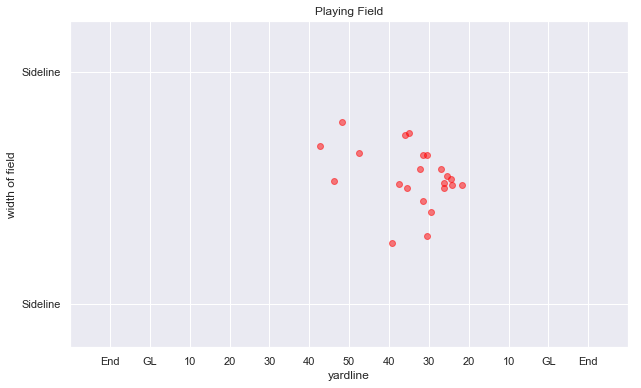

In [14]:
'''SCRIPT WITHOUT TEAM LABELS'''
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,6))
ax.set(
    xlim=(-10, 130),
    ylim=(-10, 65),
    title='Playing Field',
    xlabel='yardline',
    ylabel='width of field'
)
plt.xticks(np.arange(0, 130, step=10),
              ['End', 'GL', '10', '20', '30', '40', '50', '40', '30', '20', '10', 'GL', 'End'])
plt.yticks(np.arange(0, 65, 53.3), ['Sideline', 'Sideline'])
scat1 = ax.scatter(the_play.loc[:21, 'x'], the_play.loc[:21, 'y'], color='red', alpha=0.5)
interval = 1

def animate(i):
    if i == 0:
        return
    else:
        scat1.set_offsets(np.c_[the_play.loc[(i*22):(i*22)+22, 'x'], 
                                the_play.loc[(i*22):(i*22)+22, 'y']])

print('Play Description:', the_play.loc[0, 'PlayDescription'])
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=int(len(the_play)/22), interval=100, repeat=False)
HTML(ani.to_jshtml())

- Let's indicate what team the player is playing on based off player role

In [15]:
return_team_positions = ['PR', 'PDL1', 'PDL2', 'PDL3', 'PDL4', 'PDR1', 'PDR2', 'PDR3', 'PDR4', 'VL', 'VR', 
                         'PLL', 'PLR', 'VRo', 'VRi', 'VLi', 'VLo', 'PLM', 'PLR1', 'PLR2', 'PLL1', 'PLL2',
                         'PFB', 'PDL5', 'PDR5', 'PDL6', 'PLR3', 'PLL3', 'PDR6', 'PLM1', 'PDM']
punt_team_positions = ['P', 'PLS', 'PPR', 'PLG', 'PRG', 'PLT', 'PRT', 'PLW', 'PRW', 'GL', 'GR',
                       'GRo', 'GRi', 'GLi', 'GLo', 'PC', 'PPRo', 'PPRi', 'PPL', 'PPLi', 'PPLo']

def label_team(df):
    '''Label each player by the team they play on'''
    df['team'] = ''

    for i, role in enumerate(df['Role']):
        if role in return_team_positions:
            df.loc[i, 'team'] = 'return team'
        elif role in punt_team_positions:
            df.loc[i, 'team'] = 'punt team'
        else:
            df.loc[i, 'team'] = 'unknown'

In [16]:
# Isolate core of the play and order dataset appropriately
label_team(the_play)
the_play.sort_values(by=['Time', 'team', 'GSISID'], inplace=True)
the_play.reset_index(drop=True, inplace=True)
the_play.shape

(3058, 11)

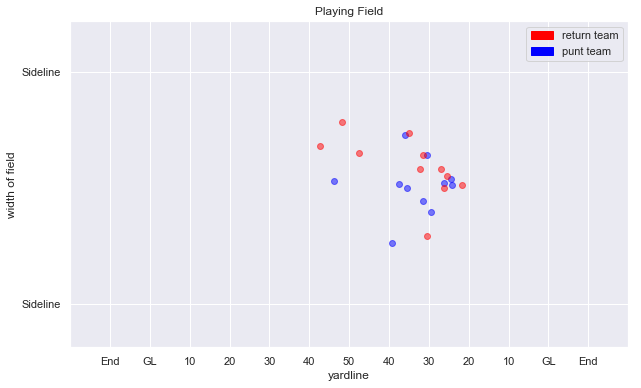

In [17]:
'''SCRIPT WITH TEAM LABELS'''
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,6))
ax.set(
    xlim=(-10, 130),
    ylim=(-10, 65),
    title='Playing Field',
    xlabel='yardline',
    ylabel='width of field'
)
plt.xticks(np.arange(0, 130, step=10),
              ['End', 'GL', '10', '20', '30', '40', '50', '40', '30', '20', '10', 'GL', 'End'])
plt.yticks(np.arange(0, 65, 53.3), ['Sideline', 'Sideline'])
red_patch = mpatches.Patch(color='red', label='return team')
blue_patch = mpatches.Patch(color='blue', label='punt team')
plt.legend(handles=[red_patch, blue_patch])

# Punt team
scat1 = ax.scatter(the_play.loc[:10, 'x'], the_play.loc[:10, 'y'], color='blue', alpha=0.5)
# Return team
scat2 = ax.scatter(the_play.loc[11:21, 'x'], the_play.loc[11:21, 'y'], color='red', alpha=0.5)

def animate(i):
    if i == 0:
        return
    else:
        # Punt team update
        scat1.set_offsets(np.c_[the_play.loc[(i*22):(i*22)+10, 'x'], 
                                the_play.loc[(i*22):(i*22)+10, 'y']])
        # return team update
        scat2.set_offsets(np.c_[the_play.loc[(i*22)+11:(i*22)+21, 'x'], 
                                the_play.loc[(i*22)+11:(i*22)+21, 'y']])      
        
        
print('Play Description:', the_play.loc[0, 'PlayDescription'])
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=int(len(the_play)/22), interval=100, repeat=False)
HTML(ani.to_jshtml())

In [18]:
# To check for timestamps that are missing players
time_ids = the_play.groupby(['Time']).size().reset_index().rename(columns={0:'count'})
time_ids['count'].value_counts()

22    139
Name: count, dtype: int64

- <b>If you experience color switching during a play</b>, it is due to some timestamps (one tenth of a second in time) having less than 22 data points associated with it. I have not figured a way to label particular data points without bogging down the runtime of creation of the animation. My assumption of 22 players across all timestamps fails at times :(. I could probably make my scripts more dynamic to account for the changing number of players being tracked throughout the play, but I'm tired :P.
- <b>Hopefully checking game animations can help folk see how some plays panout</b>
- I'll try updating in a future version to have little sticks with player facing directions

- o: player facing direction
- d: player momentum direction
- 0* is to the north and increases counter-clockwise

In [19]:
# Need to convert degrees to directional angle for the arrow

\

def direction 
np.sin(q_rows['o']*2*np.pi/360)

SyntaxError: invalid syntax (<ipython-input-19-3d9ac7136614>, line 5)

In [ ]:
plt.arrow(1, 2, 1, 1, head_width = 0.5, shape='full')
plt.xlim(0, 5)
plt.ylim(0, 5)